#  Data Processing

- The resulting dataset that we should use for modeling going forward is `Data/working_dataset_v1.pkl`
- only missing values are in doc2vec and cos_angle (3.23%, missing vals in doc2vec is a subset of cos_angle)
- 29% of values of `parent_score` were missing. These values were imputed with the median of 4. Since this feature is very important, we should consider other imputations, but not using the score column since this is our target variable

In [1]:
import pandas as pd
processed_data = pd.read_pickle('Data/working_dataset_v1.pkl')
f"{processed_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.637981514513919 GB'

### Load Libraries

In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feather

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read in Original Data

In [2]:
path = Path('./Data/May2015_subset.fthr')
df = feather.read_dataframe(path)
# df = pd.read_feather('Data/May2015_subset.fthr')

## Preliminary EDA

### Size and features

In [3]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'5.128976683577038 GB'

- `created_utc` - the time (in seconds) when the comment was posted 
- `ups` - number of upvotes on the comment
- `subreddit_id` - id of the specific subreddit
- `link_id` - id of the particular comment thread
- `name` - name of the comment
- `score_hidden` - 1 if the score of the comment was hidden; 0 else
- `author_flair_css_class` - 
- `author_flair_text` - 
- `id` - id of the comment (basically the same as comment name)
- `removal_reason` - reason a comment was removed (either `legal` or `None`)
- `gilded` - the number of gilded tags (~ premium likes) on the comment 
- `downs` - number of downvotes on the comment
- `archived` - if the thread was archived (no new comments, no new likes) 
- `author` - author's reddit username
- `score` - `ups - downs`
- `retrieved_on` - The time (in seconds) when the comment was pulled to create the dataset. 
- `body` - the comment itself
- `distinguished` - the type of user on the page. Either `moderator`, `admin`, or `None`. 
- `edited` - whether (1) or not (0) the comment has been edited
- `controversiality` - a Boolean indicating whether (1) or not (0) a comment is controversial -- i.e., popular comments that are getting closely the same amount of upvotes as downvotes. 
- `parent_id` - the id of the comment that this comment was replying to. `None` if the comment is not a reply

In [4]:
df.head(3).T

,0,1,2
created_utc,1430438402,1430438411,1430438412
ups,1,12,1
subreddit_id,t5_2qh22,t5_2qh22,t5_2qh22
link_id,t3_34gb0n,t3_34gfze,t3_34b6gv
name,t1_cqug92d,t1_cqug99n,t1_cqug9aa
score_hidden,0,0,0
author_flair_css_class,None,MAL,MAL
author_flair_text,None,http://myanimelist.net/animelist/Link_of_Hyrule,http://myanimelist.net/profile/TenWoTsuke
subreddit,anime,anime,anime
id,cqug92d,cqug99n,cqug9aa


## Feature Engineering

Let's look at the size of the dataframe & explore if we want to build a model using all of the observations. 

In [5]:
df.shape

(6195172, 22)

The dataset houses 6,195,172 comments! Let's explore options of narrowing this dataset down. Our first idea is to handpick a set of subreddits. Let's visualize subreddits based on comments. 

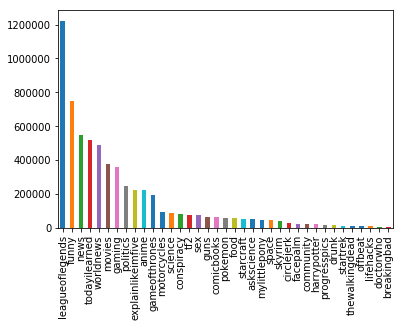

In [6]:
df.subreddit.value_counts().plot(kind='bar')
plt.show()

We'll narrow down our dataset to five popular subreddits on simple topics – [`worldnews`, `movies`, `gaming`, `science`, `food`]

In [7]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']
df = df[df.subreddit.isin(subreddit_list)]

Focusing on specific subreddits has narrowed our number of observations down from 6,195,172 to a much more manageable 1,372,864 comments, a reduction of 4,822,308 observations.

Let's explore our the number of observations in our hand-picked subreddits. 

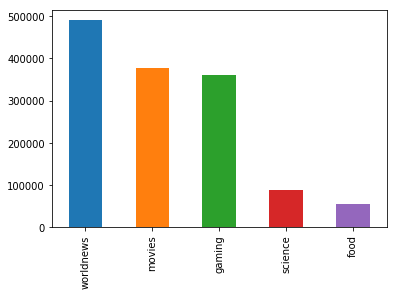

In [8]:
df.subreddit.value_counts().plot(kind='bar')
plt.show()

**Type Conversion** We need to make sure that we are handling categorical variables appropriately. 

In [9]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

**Deleting Features** In exploring the data, we found that some variables are not helpful for us in our efforts to predict reddit scores. Here are variables that we chose to remove, with a quick reason why we chose to do so – 
- `archived` - There are no archived comments in our reduced dataset. 
- `retrieved_on` - Retrieved at least 104 hours after the comment, far long enough for most threads to die. 
- `id` - The variable `name` also uniquely identifies comments, rendering `id` irrelevant. 
- `author_flair_css_class` - Exploration of using this variable & `author_flair_text` proved fruitless.
- `author_flair_text` - Ditto
- `removal_reason` - Only 7 comments were deleted (`removal_reason = legal`). We will treat those comments as outliers that would not help in predicting the scores of new comments. 

In [10]:
# The number of hours between when the comment was posted & when it was scraped
t = (df.retrieved_on - df.created_utc) / 60 / 60
t.min()

104.2038888888889

In [11]:
# Remove superfluous explanatory variables
df.drop(['archived', 'retrieved_on', 'id',
         'author_flair_css_class', 'author_flair_text',
         'removal_reason'], axis=1, inplace=True)

**Specific Feature Touch-Ups** We need to edit some features to make them more useful to us. 

In [12]:
# Replace 'NaN' with 'user'
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

# Convert created_utc to datetime
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [13]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'subreddit', 'gilded', 'downs', 'author', 'score', 'body',
       'distinguished', 'edited', 'controversiality', 'parent_id', 'time'],
      dtype='object')

**Size**

In [14]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.7425327008497477 GB'

Note that we have narrowed our dataset from `5.13GB` to `0.73GB`. Quite a reduction!

## Additional Variable Creation

- `time_lapse` - (in seconds) An interesting feature for a given observation would be the amount of time since the first comment in a thread. Let's calculate this. 

In [15]:
# Find the time of the first comment in a thread
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

# Create a dictionary of {link_id -> timestamp} pairs
df_first_comment_dict = df_first_comment.to_dict('index')

# Funct that takes in {link_id, timestamp} pair & returns the time elapsed since the first comment in that link_id.
def time_lapse(x):
    return df_first_comment_dict[x]['time']

# Add a column of the time_elapsed from the first comment in a link_id
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

# Convert the type of time_lapse back to seconds
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

An interesting observation is that there are on average `23.60` comments-per-thread.  

In [16]:
# Total comments / unique threads 
len(df.link_id) / len(df.link_id.unique())

29.494779358054398

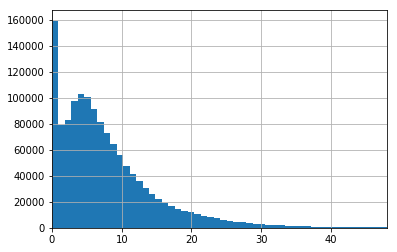

In [17]:
# hours after first comment in thread
(df.time_lapse / (60*60)).hist(bins=800).set_xlim((0, 48));

We see that most comment threads die after 40 hours. Because of this behaviour, we find that the `retrieved_on` feature is rather superfluous, as mentioned above. Thus, we don't worry that the data collection process diminished the score in any particular way. 

## Parent Based Features

- `depth`: depth of comment in its thread
- `parent_score`: score of parent comment. If no score for a `parent_id`, use median(parent_score)
- `time_since_parent`: time since parent comment in seconds

In [18]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return counter
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))
imp_val = df.parent_score.median()
df.parent_score.fillna(imp_val, inplace=True)

comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [19]:
sum(df.parent_score != df.parent_score) / len(df.parent_score)

0.0

In [20]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


## Comment Content Based Features

- `linked_sr` - A list of subreddits mentioned in the comment
- `linked_urls` - A list of urls mentioned in the comment. 
    - We'll limit the amount of URL & subreddit features to the top-15, respectively. We want to use each URL as a binary feature. We don't want the amount of URL features we are going to add to be outrageous.




Perhaps more useful features than respective arrays of subreddits & urls would be a simple count
- `no_of_linked_sr`: count of respective subreddit there were in a given comment
- `no_of_linked_urls`: count of respective urls there were in a given comment 
- `subjectivity` - Count how many times the personal pronoun `I` occurs in a comment. 
- `is_edited`: `edited` is a timestamp that indicates when the comment was last edited. Also useful would be a variable that indicates whether the comment was edited or not.
- `quoted` - Check if the comment quotes another comment. 
- `no_quoted` - Check the number of quotes in a comment

### `linked_sr`

`linked_sr` - A list of subreddits mentioned in the comment.

In [21]:
# Extract an array of subreddit links in a post & use as a feature
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

# Remove the subreddits mentioned from the actual comment
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

### `linked_urls`

`linked_urls` - A list of urls mentioned in the comment. 

In [22]:
# Nasty Regular Extraction to extract a link
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    """
    Given a comment (String), extract an array of urls' domain names mentioned in the comment
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

# Create the feature for each observation
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [23]:
def remove_urls(x):
    """
    Given a comment, replace the url component with an empty string. 
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

# Remove the URL from each comment 
df['body'] = df.body.apply(lambda x: remove_urls(x))

### `no_of_linked_sr` & `no_of_linked_urls`

`no_of_linked_sr`, `no_of_linked_urls` - Perhaps more useful features than respective arrays of subreddits & urls would be a simple count of how many respective subreddit & urls there were in a given comment

In [24]:
# Create a how-many-subreddit-links-were-in-this-comment? feature
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))

# Create a how-many-urls-were-in-this-comment? feature
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

**Notes** - On average there are `0.027` subreddits mentioned per post & `0.077` URLs per post. 

In [25]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.025753461377091977
URL-links-per-post        0.07793415808120834


Here is a list of the subreddits most referred to – 

In [26]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l

top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(15)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206)]

Here is a list of the URLs most referred to – 

In [27]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l

top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

We'll limit the amount of URL & subreddit features to the top-15, respectively. Why? We want to use each URL as a binary feature. We don't want the amount of URL features we are going to add to be outrageous. 

In [28]:
# Find the most common URLs
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

def remove_urls(x):
    """
    Given a list of URLs, keep only those in the top-15. 
    """
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

# Keep only the popular URLs 
df['linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

### `subjectivity`

`subjectivity` - Count how many times the personal pronoun `I` occurs in a comment. 

In [29]:
# Implement the above
df['subjectivity'] = df['body'].str.count('I ')

### `is_edited`

`is_edited` – `edited` is a timestamp that indicates when the comment was last edited. Also useful would be a variable that indicates whether the comment was edited or not.

In [30]:
# Create a column indicating if the comment is edited or not
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [31]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.03422188942240455'

**Notes** - Only 3% of comments were edited.

### `quoted`

`quoted` - Check if the comment quotes another comment. 

In [32]:
# if the comment quotes another comment, indicate that with a boolean
df['is_quoted'] = df.body.str.contains('&gt;')

### `no_quoted`

`no_quoted` - Check the number of quotes in a comment

In [33]:
# Implement the above
df['no_quoted'] = df.body.str.count('&gt;')

In [34]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


**Notes**
- On average there are `0.027` subreddits mentioned per post & `0.077` URLs per post. 
- Only 3% of comments were edited.
- subjectivity is highly skewed, maybe categorical would be better

In [35]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.025753461377091977
URL-links-per-post        0.07793415808120834


In [36]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.03422188942240455'

Here is a list of the subreddits most referred to – 

In [37]:
top_sr_links.most_common(15)

[('worldnews', 4946),
 ('worldnews)', 2796),
 ('worldnews.', 2489),
 ('help', 2387),
 ('worldnews](http:', 2387),
 ('food),', 1594),
 ('gaming', 1435),
 ('food)', 1283),
 ('movies', 1225),
 ('science', 1044),
 ('movies)', 467),
 ('EverythingScience.', 459),
 ('AutoModerator', 452),
 ('conspiracy', 241),
 ('science.', 206)]

Here is a list of the URLs most referred to – 

In [38]:
top_url_links.most_common(15)

[('reddit', 20232),
 ('youtube', 14216),
 ('wikipedia', 11078),
 ('imgur', 8154),
 ('youtu', 3616),
 ('redditblog', 2393),
 ('imdb', 2132),
 ('co', 1811),
 ('theguardian', 823),
 ('google', 733),
 ('github', 606),
 ('wordpress', 556),
 ('nytimes', 508),
 ('twitter', 432),
 ('amazon', 425)]

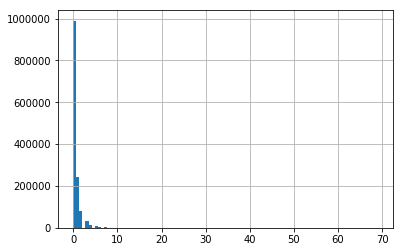

In [39]:
df.subjectivity.hist(bins=100)
plt.show()

In [40]:
df.head(3).T

,732330,732331,732332
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
subreddit,food,food,food
gilded,0,0,0
downs,0,0,0
author,FightWithTools,BlakShuck,westhest


## Sentiment Based Features

This cell will take a few minutes to run.
-  `senti_neg`: negative score of comment
- `senti_neu`: neutral score of comment
- `senti_pos`: positive score of comment
- `senti_comp`: compound score of comment

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analyzer
analyser = SentimentIntensityAnalyzer() # http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

# get sentiment scores 
def get_sentiment(x):
    return analyser.polarity_scores(x)

# get sentiment scores from 'body' column of dataframe
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

# to apply operation in parallel
num_partitions = 100
num_cores = 4
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# add a column for each score to our data
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)
sentiment.drop(['body'], axis=1, inplace=True)
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/mult

KeyboardInterrupt: 

In [ ]:
print(df.shape)
df.head(3).T

In [ ]:
# save new data
df.to_pickle('Data/working_sub.pkl')

## Comment Length Based Features

- `word_count`: number of words in comment

In [ ]:
df = pd.read_pickle('Data/working_sub.pkl')

In [ ]:
# get number of words in comment
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count
del word_counts

In [ ]:
print(df.shape)
df.head(3).T

In [ ]:
# save new data
df.to_pickle('Data/working_sub.pkl')

## Comment2Vec Based Features

- `doc2vec`: centroid of 50 dimensional word embeddings. About 2.3% are NA. This happened when either child or parent comment could not be embedded.
- `cos_angle`: cosine similarity between comment and its parent. About 3.23% are NA. This happened when either child or parent comment could not be embedded.

In [ ]:
df = pd.read_pickle('Data/working_sub.pkl')

In [ ]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector
    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]
    return terms

def doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)
    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.6B.50d.txt')

def wrapper_get_centroid(df):
    df['doc2vec'] = df['body'].apply(lambda x: doc2vec(x, gloves))
    return df

# get centroid of each comment
doc2vec_vals = parallelize_dataframe(df['body'].to_frame(), wrapper_get_centroid)
doc2vec_vals = doc2vec_vals.doc2vec.values
df['doc2vec'] = doc2vec_vals

comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')


def get_pseudo_parent(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
#             print(counter)
            return temp
        try:
#             print(temp)
            temp1 = temp
            temp = comment_to_parent[temp1]
            temp2 = comment_to_parent[temp]
        except KeyError:
#             print(counter)
#             print(':(')
            return temp1
        counter += 1
        
# print(get_pseudo_parent('t1_cquhctp)

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        try:
            parent = comment_to_body[get_pseudo_parent(cmnt_id)]
        except KeyError:
            return np.nan
    child = doc2vec(child, gloves)
    parent = doc2vec(parent, gloves)
    if child is None:
        return np.nan
    if parent is None:
        return np.nan
    return child.dot(parent)

def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

# get cosine angle between comment and its parent's comment centroid
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)
df['cos_angle'] = cosine_angle.cosine_angle
del gloves
del doc2vec
del cosine_angle

In [ ]:
print(df.shape)
df.head(3).T

In [ ]:
# pd.read_pickle('Data/working_dataset_v1.pkl')

In [ ]:
sum(df.doc2vec != df.doc2vec) / len(df.doc2vec)

In [ ]:
sum(df.cos_angle != df.cos_angle) / len(df.cos_angle)

In [ ]:
# save new data
df.to_pickle('Data/working_dataset_v1.pkl')

In [ ]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"